In [1]:
import geopandas as gpd
import pyogrio as ogr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps

In [2]:
# bounding box of nyc
bbox = (-74.3, 40.5, -73.7, 40.9)

In [4]:
# create a geodataframe of 100 random points
np.random.seed(0)
n = 100
df = pd.DataFrame(
    {
        "geometry": gpd.points_from_xy(
            np.random.uniform(-74.3, -73.7, n),
            np.random.uniform(40.5, 40.9, n),
        ),
    }
)

In [5]:
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")

<Axes: >

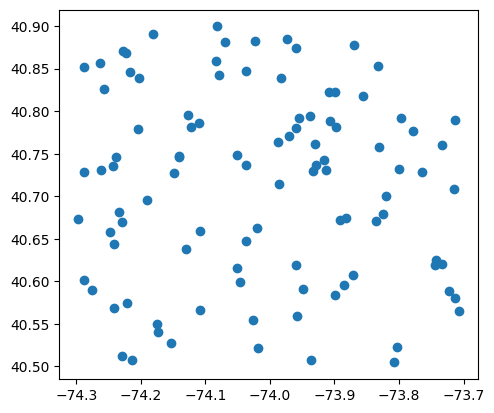

In [6]:
gdf.plot()

In [7]:
# find five nearest neighbors for each point, not including itself
k = 5
neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(
    axis=1
)[:, 1 : k + 1]

# join neighbors to original dataframe
gdf["neighbors"] = neighbors.tolist()

C:\Users\cathe\AppData\Local\Temp\ipykernel_24080\2007509322.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(


In [8]:
gdf

,geometry,neighbors
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]"
1,POINT (-73.87089 40.60800),"[83, 91, 42, 39, 31]"
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]"
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]"
4,POINT (-74.04581 40.59950),"[29, 41, 32, 58, 80]"
...,...,...
95,POINT (-74.19009 40.69618),"[61, 24, 57, 87, 15]"
96,POINT (-73.94809 40.59097),"[33, 50, 91, 83, 1]"
97,POINT (-74.28794 40.60174),"[75, 69, 67, 15, 92]"
98,POINT (-73.80264 40.52321),"[66, 8, 52, 72, 1]"


In [9]:
def create_lines(r):
    lines = []
    for i, neighbor in enumerate(r.neighbors):
        lines.append(LineString([r.geometry, gdf.loc[neighbor].geometry]))
    return MultiLineString(lines)

In [10]:
gdf["line_geometry"] = gdf.apply(create_lines, axis=1)

In [11]:
gdf

,geometry,neighbors,line_geometry
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]","MULTILINESTRING ((-73.97071 40.77113, -73.9591..."
1,POINT (-73.87089 40.60800),"[83, 91, 42, 39, 31]","MULTILINESTRING ((-73.87089 40.60800, -73.8845..."
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]","MULTILINESTRING ((-73.93834 40.79408, -73.9544..."
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]","MULTILINESTRING ((-73.97307 40.88488, -73.9600..."
4,POINT (-74.04581 40.59950),"[29, 41, 32, 58, 80]","MULTILINESTRING ((-74.04581 40.59950, -74.0512..."
...,...,...,...
95,POINT (-74.19009 40.69618),"[61, 24, 57, 87, 15]","MULTILINESTRING ((-74.19009 40.69618, -74.2337..."
96,POINT (-73.94809 40.59097),"[33, 50, 91, 83, 1]","MULTILINESTRING ((-73.94809 40.59097, -73.9589..."
97,POINT (-74.28794 40.60174),"[75, 69, 67, 15, 92]","MULTILINESTRING ((-74.28794 40.60174, -74.2764..."
98,POINT (-73.80264 40.52321),"[66, 8, 52, 72, 1]","MULTILINESTRING ((-73.80264 40.52321, -73.8074..."


In [12]:
lines_gdf = gpd.GeoDataFrame(
    gdf[["line_geometry"]], geometry="line_geometry", crs="EPSG:4326"
)

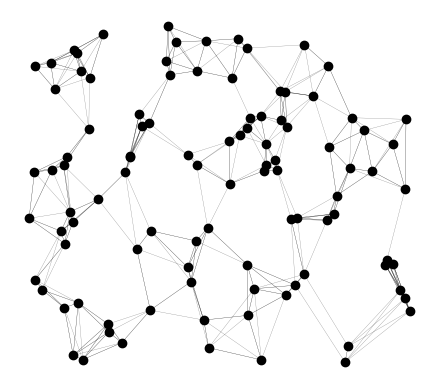

In [13]:
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="black").set_axis_off()
plt.savefig("lines.pdf", bbox_inches="tight", pad_inches=0)

<Axes: >

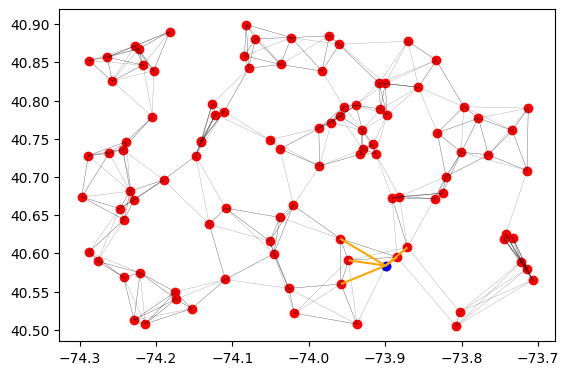

In [14]:
# plot the lines for a single point
s = gdf.sample(1)
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="red")

s.plot(ax=ax, color="blue")
gpd.GeoSeries(s.line_geometry).plot(ax=plt.gca(), color="orange")

# real-world example


## get restaurants in Morningside Heights


In [15]:
mh_restaurants = requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
).json()

In [16]:
requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
).json()


[{'camis': '50155354',
  'boro': 'Manhattan',
  'building': '1003A',
  'street': 'COLUMBUS AVE',
  'zipcode': '10025',
  'phone': '9173610786',
  'inspection_date': '1900-01-01T00:00:00.000',
  'critical_flag': 'Not Applicable',
  'record_date': '2024-08-15T06:00:14.000',
  'latitude': '40.801355201243',
  'longitude': '-73.96133023214',
  'community_board': '107',
  'council_district': '07',
  'census_tract': '019300',
  'bbl': '1',
  'nta': 'MN09'},
 {'camis': '50155259',
  'dba': "Miss Mamie's Spoonbread Too",
  'boro': 'Manhattan',
  'building': '364',
  'street': 'WEST  110 STREET',
  'zipcode': '10025',
  'phone': '3473860833',
  'inspection_date': '1900-01-01T00:00:00.000',
  'critical_flag': 'Not Applicable',
  'record_date': '2024-08-15T06:00:14.000',
  'latitude': '40.80137126967',
  'longitude': '-73.96015994361',
  'community_board': '107',
  'council_district': '07',
  'census_tract': '019300',
  'bin': '1055741',
  'bbl': '1018450003',
  'nta': 'MN09'},
 {'camis': '501473

In [17]:
mh_restaurants = gpd.GeoDataFrame(
    mh_restaurants,
    geometry=gpd.points_from_xy(
        [float(x["longitude"]) for x in mh_restaurants],
        [float(x["latitude"]) for x in mh_restaurants],
    ),
)

In [18]:
mh_restaurants.fillna("na", inplace=True)

In [19]:
mh_restaurants.columns

Index(['camis', 'boro', 'building', 'street', 'zipcode', 'phone',
       'inspection_date', 'critical_flag', 'record_date', 'latitude',
       'longitude', 'community_board', 'council_district', 'census_tract',
       'bbl', 'nta', 'dba', 'bin', 'cuisine_description', 'action',
       'violation_code', 'violation_description', 'score', 'grade',
       'grade_date', 'inspection_type', 'geometry'],
      dtype='object')

In [20]:
mh_restaurants.drop_duplicates(subset="camis", inplace=True)

In [21]:
mh_restaurants.grade.value_counts()

grade
na    82
A     69
N      8
B      7
C      2
Name: count, dtype: int64

In [22]:
mh_restaurants.cuisine_description.value_counts()

cuisine_description
American                          26
Coffee/Tea                        20
na                                16
Chinese                           10
Pizza                              9
Mexican                            8
Italian                            8
Japanese                           5
Juice, Smoothies, Fruit Salads     4
Sandwiches                         4
Hamburgers                         4
French                             4
Asian/Asian Fusion                 4
Other                              3
Thai                               3
Indian                             3
Ethiopian                          3
Hawaiian                           2
Fusion                             2
Sandwiches/Salads/Mixed Buffet     2
Mediterranean                      2
Tex-Mex                            2
Latin American                     2
Middle Eastern                     2
Donuts                             2
Frozen Desserts                    2
Bakery Products/De

## build graph to allow us to search


In [23]:
mh_bbox = mh_restaurants.total_bounds

In [24]:
mh_bbox

array([-73.96804436,  40.79882472, -73.9527956 ,  40.81532499])

In [25]:
mh_network = ox.graph_from_bbox(
    mh_bbox[3], mh_bbox[1], mh_bbox[2], mh_bbox[0], network_type="walk"
)

C:\Users\cathe\AppData\Local\Temp\ipykernel_24080\307712133.py:1: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  mh_network = ox.graph_from_bbox(


In [26]:
mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network)

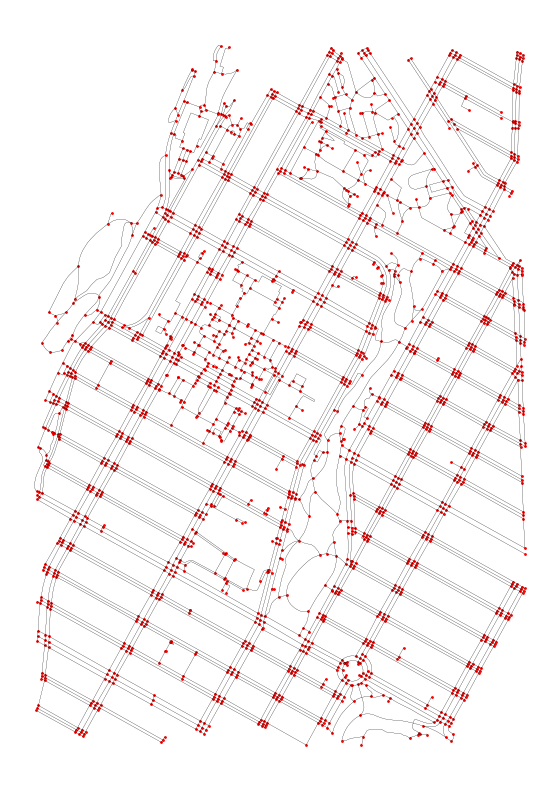

In [27]:
ax = mh_net_edges.plot(color="black", linewidth=0.1, figsize=(10, 10))
mh_net_nodes.plot(ax=ax, color="red", markersize=1).set_axis_off()

In [28]:
avery_hall = Point(-73.9614755, 40.8081037)

### get directions between avery hall and a random restaurant using osmnx


In [29]:
# get the nearest node to avery hall
orig = ox.distance.nearest_nodes(mh_network, avery_hall.x, avery_hall.y)
sample = mh_restaurants.sample(1)
dest = ox.distance.nearest_nodes(mh_network, sample.geometry.x, sample.geometry.y)[0]

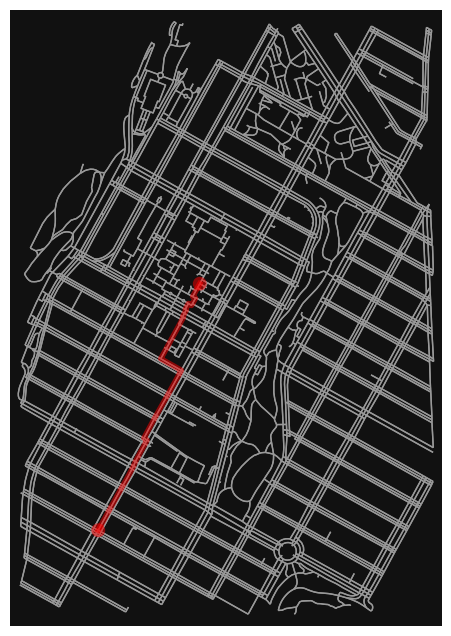

In [30]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(mh_network, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(mh_network, route, node_size=0)

In [31]:
edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

# convert meters to miles
sum(edge_lengths) / 1609.34

0.5797606472218425

In [32]:
mh_pizza = mh_restaurants[mh_restaurants.cuisine_description == "Pizza"]

<Axes: >

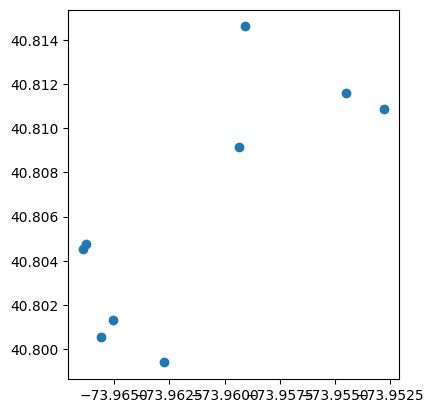

In [33]:
mh_pizza.plot()

In [34]:
def distance_from_point(row, origin):
    """
    Returns the distance in miles and the geometry of the shortest path between a point and a destination.

    Parameters:
    row (pd.Series): A row from a pandas DataFrame.
    origin (int): The origin node in the network.
    """

    dest = ox.distance.nearest_nodes(mh_network, row.geometry.x, row.geometry.y)  # [0]
    route = ox.shortest_path(mh_network, origin, dest, weight="length")
    edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

    route_geom = ox.routing.route_to_gdf(mh_network, route)
    route_geom = route_geom.geometry.unary_union

    return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}

In [35]:
mh_pizza["distance_from_avery"] = mh_pizza.apply(
    distance_from_point, origin=orig, axis=1
)

c:\ProgramData\anaconda3\envs\cdp\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [36]:
mh_pizza["distance_from_avery"]

8      {'distance': 0.6333391328122088, 'route_geom':...
22     {'distance': 0.5736600096934148, 'route_geom':...
31     {'distance': 0.42345557806305695, 'route_geom'...
104    {'distance': 0.42345557806305695, 'route_geom'...
140    {'distance': 0.6302254340288566, 'route_geom':...
149    {'distance': 0.5797606472218425, 'route_geom':...
174    {'distance': 0.24633514359923947, 'route_geom'...
389    {'distance': 0.7407987125156896, 'route_geom':...
428    {'distance': 0.7203083251519257, 'route_geom':...
Name: distance_from_avery, dtype: object

In [37]:
# explode the dictionary into separate columns
mh_pizza = pd.concat(
    [
        mh_pizza.drop(["distance_from_avery"], axis=1),
        mh_pizza["distance_from_avery"].apply(pd.Series),
    ],
    axis=1,
)

In [38]:
mh_pizza


,camis,boro,building,street,zipcode,phone,inspection_date,critical_flag,record_date,latitude,...,action,violation_code,violation_description,score,grade,grade_date,inspection_type,geometry,distance,route_geom
8,40605511,Manhattan,409,WEST 125 STREET,10027,2122803200,2022-03-07T00:00:00.000,Critical,2024-08-15T06:00:10.000,40.811587862688,...,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,18,na,na,Cycle Inspection / Initial Inspection,POINT (-73.95451 40.81159),0.633339,"MULTILINESTRING ((-73.9614097 40.8080454, -73...."
22,50107497,Manhattan,3161,BROADWAY,10027,9172386330,2024-04-30T00:00:00.000,Critical,2024-08-15T06:00:10.000,40.814617034521,...,Violations were cited in the following area(s).,05D,No hand washing facility in or adjacent to toi...,60,N,na,Cycle Inspection / Initial Inspection,POINT (-73.95908 40.81462),0.573660,"MULTILINESTRING ((-73.9614097 40.8080454, -73...."
31,50066109,Manhattan,2848,BROADWAY,10025,2122221566,2024-07-11T00:00:00.000,Critical,2024-08-15T06:00:10.000,40.80453796204,...,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,36,na,na,Cycle Inspection / Initial Inspection,POINT (-73.96641 40.80454),0.423456,"MULTILINESTRING ((-73.9614097 40.8080454, -73...."
104,40388419,Manhattan,2859,BROADWAY,10025,2128651234,2022-03-17T00:00:00.000,Not Critical,2024-08-15T06:00:10.000,40.804776710519,...,Violations were cited in the following area(s).,09C,Food contact surface not properly maintained.,29,C,2022-03-17T00:00:00.000,Cycle Inspection / Re-inspection,POINT (-73.96626 40.80478),0.423456,"MULTILINESTRING ((-73.9614097 40.8080454, -73...."
140,41012973,Manhattan,941,AMSTERDAM AVENUE,10025,2125319797,2022-02-10T00:00:00.000,Not Critical,2024-08-15T06:00:10.000,40.800549608118,...,Violations were cited in the following area(s).,20F,Current letter grade sign not posted.,na,na,na,Administrative Miscellaneous / Initial Inspection,POINT (-73.96561 40.80055),0.630225,"MULTILINESTRING ((-73.9614097 40.8080454, -73...."
149,50046844,Manhattan,965,AMSTERDAM AVENUE,10025,2122222000,2022-04-05T00:00:00.000,Not Applicable,2024-08-15T06:00:12.000,40.801293269011,...,No violations were recorded at the time of thi...,na,na,na,na,na,Calorie Posting / Initial Inspection,POINT (-73.96507 40.80129),0.579761,"MULTILINESTRING ((-73.9614097 40.8080454, -73...."
174,50073062,Manhattan,1215,AMSTERDAM AVENUE,10027,9177141411,2023-05-02T00:00:00.000,Not Critical,2024-08-15T06:00:10.000,40.809149594666,...,Violations were cited in the following area(s).,10F,Non-food contact surface or equipment made of ...,2,A,2023-05-02T00:00:00.000,Cycle Inspection / Re-inspection,POINT (-73.95934 40.80915),0.246335,"MULTILINESTRING ((-73.9614097 40.8080454, -73...."
389,50134260,Manhattan,940,COLUMBUS AVENUE,10025,4692840850,2024-04-04T00:00:00.000,Critical,2024-08-15T06:00:10.000,40.799387691042,...,Violations were cited in the following area(s).,04A,Food Protection Certificate (FPC) not held by ...,12,A,2024-04-04T00:00:00.000,Pre-permit (Operational) / Initial Inspection,POINT (-73.96277 40.79939),0.740799,"MULTILINESTRING ((-73.9614097 40.8080454, -73...."
428,50131886,Manhattan,351,WEST 125 STREET,10027,9172658973,2023-04-27T00:00:00.000,Not Critical,2024-08-15T06:00:10.000,40.810857068175,...,Violations were cited in the following area(s).,10F,Non-food contact surface or equipment made of ...,3,A,2023-04-27T00:00:00.000,Cycle Inspection / Initial Inspection,POINT (-73.95280 40.81086),0.720308,"MULTILINESTRING ((-73.9614097 40.8080454, -73...."


In [39]:
mh_pizza_routes = gpd.GeoDataFrame(mh_pizza, geometry="route_geom", crs="EPSG:4326")

Text(0.5, 1.0, 'Distance from Avery Hall to \n Morningside Heights Pizza Restaurants')

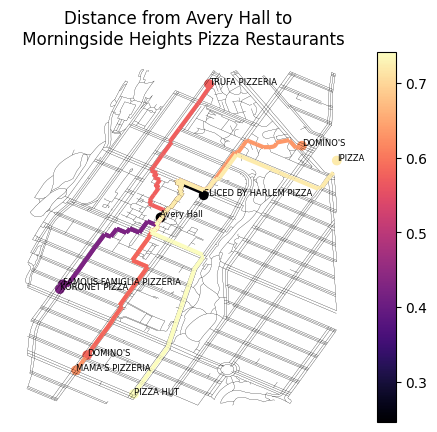

In [40]:
ax = gpd.GeoSeries(avery_hall).plot(color="black")
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)
mh_pizza_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=3)
mh_pizza.plot(column="distance", cmap="magma", legend=True, ax=ax).set_axis_off()


# label each point
for x, y, label in zip(mh_pizza.geometry.x, mh_pizza.geometry.y, mh_pizza.dba):
    ax.text(x, y, label, fontsize=6)
ax.text(avery_hall.x, avery_hall.y, "Avery Hall", fontsize=6)

# title
plt.title("Distance from Avery Hall to \n Morningside Heights Pizza Restaurants")

In [41]:
mh_pizza[["dba", "distance"]].sort_values("distance")

,dba,distance
174,SLICED BY HARLEM PIZZA,0.246335
31,KORONET PIZZA,0.423456
104,FAMOUS FAMIGLIA PIZZERIA,0.423456
22,TRUFA PIZZERIA,0.573660
149,DOMINO'S,0.579761
140,MAMA'S PIZZERIA,0.630225
8,DOMINO'S,0.633339
428,IPIZZA,0.720308
389,PIZZA HUT,0.740799


<Axes: >

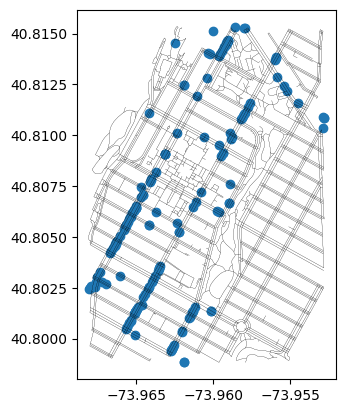

In [42]:
ax = mh_restaurants.plot()
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)

In [43]:
# use H3 grid to create a hexagon around the restaurants
# count the number of restaurants in each hexagon
# use pysal to get adjacency between hexagons
# build new network with hexagons as nodes and their adjacency as edges
# use networkx to find the shortest path between hexagons

# get the H3 hexagons

In [44]:
mh_net_nodes

,y,x,highway,street_count,geometry
osmid,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,POINT (-73.96287 40.79924)
42421741,40.800429,-73.965691,traffic_signals,4,POINT (-73.96569 40.80043)
42421745,40.801398,-73.967996,traffic_signals,4,POINT (-73.96800 40.80140)
42421852,40.812622,-73.956823,traffic_signals,3,POINT (-73.95682 40.81262)
42421857,40.813822,-73.959800,traffic_signals,4,POINT (-73.95980 40.81382)
...,...,...,...,...,...
12029862491,40.808739,-73.965726,crossing,4,POINT (-73.96573 40.80874)
12029862492,40.808069,-73.964123,crossing,4,POINT (-73.96412 40.80807)
12029862493,40.808442,-73.965017,crossing,4,POINT (-73.96502 40.80844)


In [45]:
mh_net_nodes["h3"] = mh_net_nodes.apply(
    lambda x: h3.geo_to_h3(x.geometry.centroid.y, x.geometry.centroid.x, 9), axis=1
)

In [46]:
mh_net_nodes["h3"]

osmid
42421737       892a10088b3ffff
42421741       892a1008887ffff
42421745       892a100888fffff
42421852       892a1008c33ffff
42421857       892a1008c07ffff
                    ...       
12029862491    892a1008c67ffff
12029862492    892a1008c2bffff
12029862493    892a1008c67ffff
12029862494    892a1008c67ffff
12036804275    892a1008d4bffff
Name: h3, Length: 1988, dtype: object

In [47]:
# create hexagons for AOI
mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(
    lambda x: (h3.h3_to_geo_boundary(x))
)

C:\Users\cathe\AppData\Local\Temp\ipykernel_24080\2385662124.py:2: UserWarning: Geometry column does not contain geometry.
  mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(


In [48]:
# flip order of coordinates for each tuple
mh_net_nodes["geometry"] = mh_net_nodes["geometry"].apply(
    lambda x: Polygon([(y, x) for x, y in x])
)

In [49]:
mh_net_nodes.crs = "EPSG:4326"

In [50]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [51]:
# mh_net_edges.to_crs("EPSG:2263", inplace=True)
# mh_net_nodes.to_crs("EPSG:2263", inplace=True)

In [52]:
mh_net_nodes

,y,x,highway,street_count,geometry,h3
osmid,,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,"POLYGON ((-73.96198 40.79993, -73.96409 40.798...",892a10088b3ffff
42421741,40.800429,-73.965691,traffic_signals,4,"POLYGON ((-73.96422 40.80251, -73.96633 40.801...",892a1008887ffff
42421745,40.801398,-73.967996,traffic_signals,4,"POLYGON ((-73.96850 40.80240, -73.97061 40.801...",892a100888fffff
42421852,40.812622,-73.956823,traffic_signals,3,"POLYGON ((-73.95607 40.81332, -73.95818 40.812...",892a1008c33ffff
42421857,40.813822,-73.959800,traffic_signals,4,"POLYGON ((-73.95831 40.81590, -73.96042 40.814...",892a1008c07ffff
...,...,...,...,...,...,...
12029862491,40.808739,-73.965726,crossing,4,"POLYGON ((-73.96667 40.81039, -73.96878 40.809...",892a1008c67ffff
12029862492,40.808069,-73.964123,crossing,4,"POLYGON ((-73.96239 40.81050, -73.96450 40.809...",892a1008c2bffff
12029862493,40.808442,-73.965017,crossing,4,"POLYGON ((-73.96667 40.81039, -73.96878 40.809...",892a1008c67ffff


In [53]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

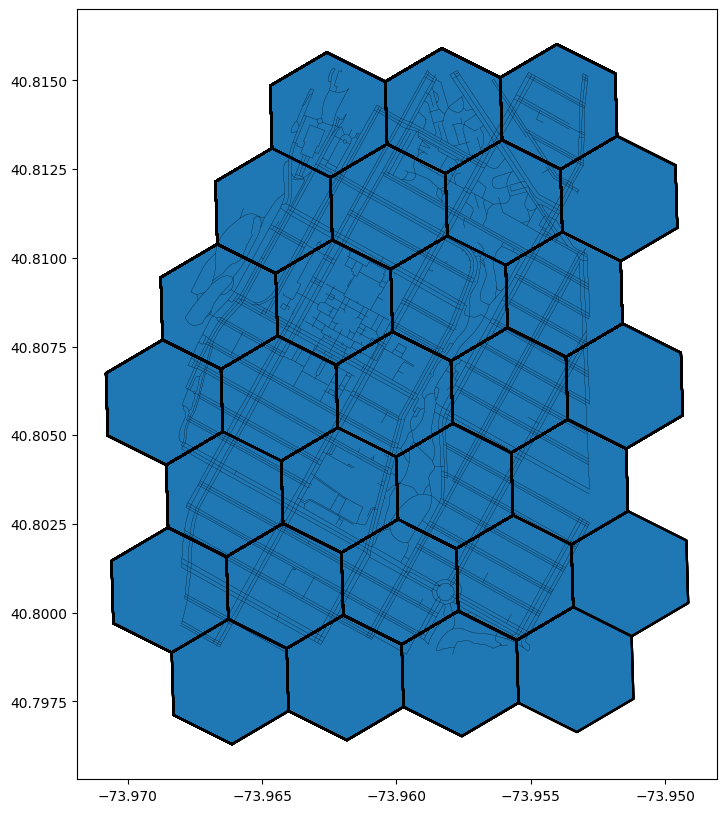

In [54]:
ax = mh_net_nodes.plot(figsize=(10, 10))
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_edges.plot(
    ax=ax,
    color="black",
    linewidth=0.1,
)  # .set_axis_off()

In [55]:
from lonboard import Map, PolygonLayer

In [56]:
layer = PolygonLayer.from_geopandas(
    mh_net_nodes[["geometry"]],
    get_line_color="black",
    get_fill_color="none",
    get_line_width=3,
)
# edges_layer = LineLayer.from_geopandas(
#     mh_net_edges[["geometry"]],
#     get_line_color="black",
#     get_fill_color="none",
#     get_line_width=1,
# )
m = Map(
    [
        layer,
    ]
)
m

Map(layers=[PolygonLayer(get_fill_color=(0, 0, 0, 0), get_line_color=(0, 0, 0, 255), get_line_width=3.0, table…

In [57]:
mh_net_nodes.drop_duplicates(subset="h3", inplace=True)

In [58]:
# create an adjacency matrix for the hexagons
w = lps.weights.Queen.from_dataframe(mh_net_nodes)

C:\Users\cathe\AppData\Local\Temp\ipykernel_24080\2435529990.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Queen.from_dataframe(mh_net_nodes)


In [59]:
# get neighbors for each hexagon
neighbors = {k: v for k, v in w.neighbors.items()}

In [60]:
neighbors

{0: [1, 18, 17, 23],
 1: [0, 2, 18, 6, 23, 12],
 2: [1, 6, 23],
 3: [16, 4, 21, 22, 8, 11],
 4: [8, 3, 5, 22],
 5: [8, 24, 4],
 6: [1, 2, 7, 12, 13],
 7: [19, 6, 25, 27, 12, 13],
 8: [3, 4, 5, 24, 27, 11],
 9: [16, 10, 20],
 10: [16, 19, 20, 9, 11, 15],
 11: [16, 3, 19, 8, 10, 27],
 12: [1, 18, 19, 6, 7, 15],
 13: [25, 6, 7],
 14: [17, 18, 20, 26, 28, 15],
 15: [18, 19, 20, 10, 12, 14],
 16: [3, 21, 9, 10, 11],
 17: [0, 18, 26, 14],
 18: [0, 1, 17, 12, 14, 15],
 19: [7, 27, 10, 11, 12, 15],
 20: [9, 10, 28, 14, 15],
 21: [16, 3, 22],
 22: [3, 4, 21],
 23: [0, 1, 2],
 24: [8, 25, 27, 5],
 25: [24, 27, 13, 7],
 26: [17, 28, 14],
 27: [19, 7, 8, 24, 11, 25],
 28: [26, 20, 14]}

In [61]:
# create networkx graph from adjacency matrix
G = nx.Graph(neighbors)

In [62]:
# get the path between two nodes
path = nx.shortest_path(G, 28, 18)

C:\Users\cathe\AppData\Local\Temp\ipykernel_24080\1576104426.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.x,
C:\Users\cathe\AppData\Local\Temp\ipykernel_24080\1576104426.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.y,


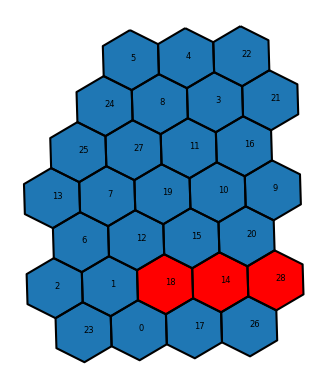

In [63]:
# plot the path
ax = mh_net_nodes.plot()
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_nodes.iloc[path].plot(ax=ax, color="red").set_axis_off()

# label cells with their index
for x, y, label in zip(
    mh_net_nodes.geometry.centroid.x,
    mh_net_nodes.geometry.centroid.y,
    neighbors.keys(),
):
    ax.text(x, y, label, fontsize=6)